In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import docplex, max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# DOcplex
from docplex.mp.model import Model

In [2]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

distance
 [[ 0. 59. 71.]
 [59.  0. 35.]
 [71. 35.  0.]]


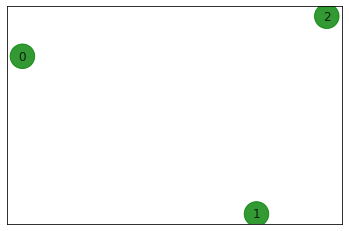

In [3]:
# Generating a graph of 3 nodes
n = 3
#num_qubits = n ** 2
ins = tsp.random_tsp(n)
#ins = tsp.parse_tsplib_format()
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['g' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

In [4]:
# Create an instance of a model and variables
mdl = Model(name='tsp')
x = {(i,p): mdl.binary_var(name='x{0}{1}'.format(i,p)) for i in range(n) for p in range(n)}

# Object function
tsp_func = mdl.sum(ins.w[i,j] * x[(i,p)] * x[(j,(p+1)%n)] for i in range(n) for j in range(n) for p in range(n))
mdl.minimize(tsp_func)

# Constrains
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)
    
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: tsp

Minimize
 obj: [ 118 x00*x11 + 118 x00*x12 + 142 x00*x21 + 142 x00*x22 + 118 x01*x10
      + 118 x01*x12 + 142 x01*x20 + 142 x01*x22 + 118 x02*x10 + 118 x02*x11
      + 142 x02*x20 + 142 x02*x21 + 70 x10*x21 + 70 x10*x22 + 70 x11*x20
      + 70 x11*x22 + 70 x12*x20 + 70 x12*x21 ]/2
Subject To
 c1: x00 + x01 + x02 = 1
 c2: x10 + x11 + x12 = 1
 c3: x20 + x21 + x22 = 1
 c4: x00 + x10 + x20 = 1
 c5: x01 + x11 + x21 = 1
 c6: x02 + x12 + x22 = 1

Bounds
 0 <= x00 <= 1
 0 <= x01 <= 1
 0 <= x02 <= 1
 0 <= x10 <= 1
 0 <= x11 <= 1
 0 <= x12 <= 1
 0 <= x20 <= 1
 0 <= x21 <= 1
 0 <= x22 <= 1

Binaries
 x00 x01 x02 x10 x11 x12 x20 x21 x22
End



In [5]:
qubitOp, offset = docplex.get_operator(mdl)
print(qubitOp)
print("offset: ", offset)

Representation: paulis, qubits: 9, size: 45
offset:  6193.5


In [6]:
# checking the full Hamiltonian
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

energy: -6028.5
tsp objective: 165.0
feasible: True
solution: [0, 2, 1]
solution objective: 165.0


/opt/conda/lib/python3.7/site-packages/qiskit/optimization/ising/tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


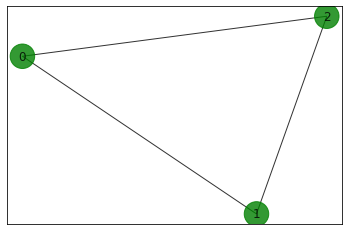

In [7]:
draw_tsp_solution(G, z, colors, pos)

In [8]:
print(result)

{'eigvals': array([-6028.5+0.j]), 'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [9]:
# Statevector simulation
seed = 10598
spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed,seed_transpiler=seed)
result = vqe.run(quantum_instance)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('solution objective:', result['energy'] + offset)
print('solution:', x)

energy: -5955.856439981681
time: 33.64276742935181
solution objective: 237.64356001831857
solution: [0. 0. 1. 1. 0. 0. 0. 1. 0.]


/opt/conda/lib/python3.7/site-packages/qiskit/optimization/ising/tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


In [10]:
print(result)

{'num_optimizer_evals': None, 'min_val': -5955.856439981681, 'opt_params': array([ 0.24071455, -1.89630935, -0.47784466,  2.98279086,  1.20989517,
       -2.46514048,  2.75266018,  3.01214692,  0.11917397, -0.70029879,
        1.12733905, -2.98571898, -4.52086598,  2.18951971, -4.93647133,
        2.58870351, -3.00365323,  3.1546977 , -0.15295833, -3.32562962,
        2.1062754 ,  2.53279465,  3.46281442, -1.55323924, -1.24611565,
       -0.06598216, -3.6033521 ,  5.41727232,  0.09569833,  0.14824464,
       -2.44472247, -3.17475803,  0.30031636, -4.1392462 , -0.12227227,
        2.2516927 ,  7.01148125,  2.16513035,  1.6740557 ,  2.24467202,
       -2.8729626 ,  0.52406818,  3.81352167, -3.05249134,  3.31097708,
       -0.93243252, -0.36368602, -1.25593523,  1.11404293, -0.61158094,
       -1.22447221, -1.841945  ,  0.35133462,  4.99021037]), 'eval_time': 33.64276742935181, 'eval_count': 651, 'energy': -5955.856439981681, 'eigvals': array([-5955.85643998]), 'min_vector': array([-8.319

In [11]:
# run quantum algorithm with shots
seed = 10598
spsa = SPSA(max_trials=10)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed,seed_transpiler=seed)
result = vqe.run(quantum_instance)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('solution objective:', result['energy'] + offset)
print('solution:', x)

energy: -1707.1103515625
time: 135.37596797943115
solution objective: 4486.3896484375
solution: [0 1 0 0 0 0 1 1 0]


/opt/conda/lib/python3.7/site-packages/qiskit/optimization/ising/tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


In [12]:
print(result)

{'num_optimizer_evals': None, 'min_val': -1707.1103515625, 'opt_params': array([ 2.72138708,  0.70597823,  5.07520572, -2.92995852,  7.03226485,
       -2.79524384,  5.23584613, -3.11089316,  0.34414137,  1.94518181,
        2.99602974,  0.50221067,  1.27297623,  2.36478994, -3.7300435 ,
        5.20314383, -2.13210056, -2.77082607,  6.6445002 ,  4.01617729,
       -4.2040015 ,  5.1536842 , -1.96342957,  1.8683102 ,  0.64740634,
        0.76852669,  0.76481217, -5.88012159,  3.45584632, -2.76367729,
       -0.1795021 , -5.72213282,  5.96278095,  2.97048365,  5.08192121,
       -6.43807574, -3.63743214, -0.62606463,  0.98136512,  4.83259999,
       -6.87630326,  4.00323678, -7.41793939, -0.39441531,  1.18205565,
        1.39780939, -5.71478202, -0.72007803, -2.51205388, -0.56989457,
       -2.94959846,  4.11486323, -0.90488468,  5.3504715 ]), 'eval_time': 135.37596797943115, 'eval_count': 25, 'energy': -1707.1103515625, 'eigvals': array([-1707.11035156]), 'min_vector': {'000001010': 2, 